In [1]:
import chess
from chesstransformer.models.transformer.position2move import Position2MoveModel
from safetensors.torch import safe_open
import torch
import json


In [2]:


model_path ="../logs/position2move/run_015_20251013_201611/checkpoints/best_model.pt/model.safetensors"

config =  {
                "vocab_size": 13,  # 12 piece types + empty square
                "move_vocab_size": 1968,
                "embed_dim": 512,
                "nb_transformer_layers": 8,
                "num_heads": 8,
                "dropout": 0.1,
                "kvq_bias": False,
                "mask_future": False,
            }
model = Position2MoveModel(**config)


with safe_open(model_path, framework="pt") as f:
    state_dict = {key: f.get_tensor(key) for key in f.keys()}

model.load_state_dict(state_dict)
model.eval();



In [3]:
from chesstransformer.models.tokenizer import MoveTokenizer, PostionTokenizer

move_tokenizer = MoveTokenizer()
position_tokenizer = PostionTokenizer()

Current board:


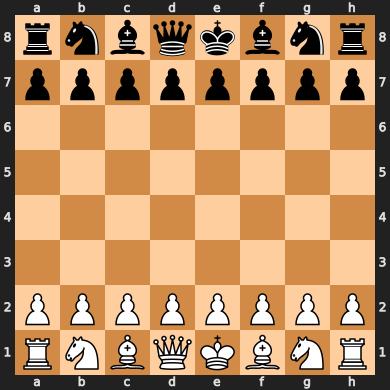

Played move: e2e4


Current board:


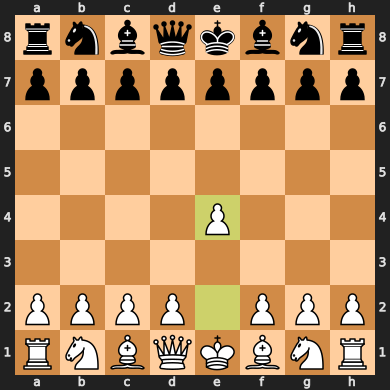

Played move: e7e5


Current board:


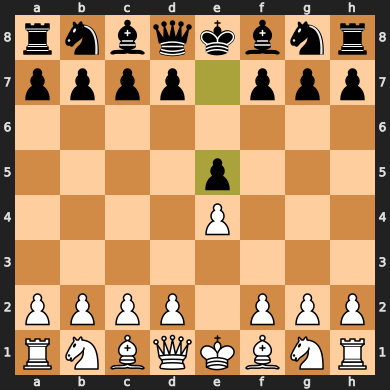

Played move: g1f3


Current board:


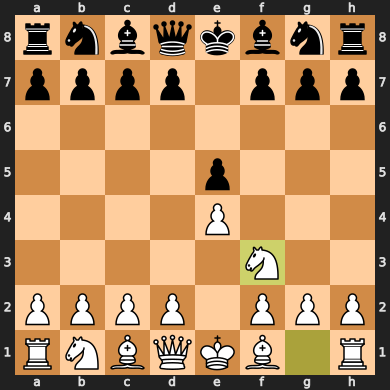

Played move: b8c6


Current board:


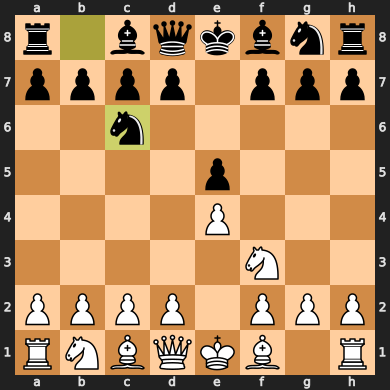

Played move: f1c4


Current board:


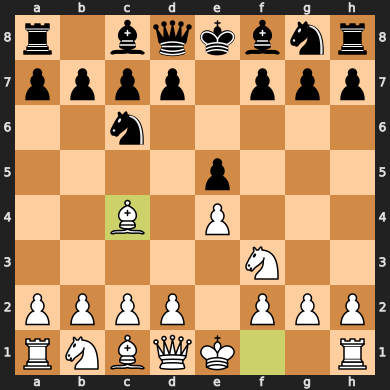

Played move: g8f6




In [4]:
board = chess.Board()

moves = ["e2e4", "e7e5", "g1f3", "b8c6", "f1c4", "g8f6"]
for move in moves:
    print("Current board:")
    display(board)
    board.push_uci(move)
    print(f"Played move: {move}")
    print("\n")
    

tokens_ids = position_tokenizer.encode(board)
torch_input = torch.tensor(tokens_ids).unsqueeze(0).long()  # Add batch dimension

is_white = board.turn
is_white = torch.tensor([is_white]).bool()  # Add batch dimension

Predicted move id: 1345 with probability 0.4642
Predicted move: f3g5
Legal moves: ['c4f7', 'c4e6', 'c4a6', 'c4d5', 'c4b5', 'c4d3', 'c4b3', 'c4e2', 'c4f1', 'f3g5', 'f3e5', 'f3h4', 'f3d4', 'f3g1', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'h2h3', 'g2g3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'd2d4', 'b2b4', 'a2a4']
Board after predicted move:


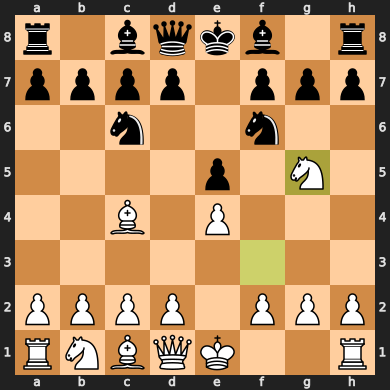

Move.from_uci('f3g5')

In [5]:
with torch.no_grad():
    logits = model(torch_input, is_white)

legal_moves = [m.uci() for m in board.legal_moves]

mask = torch.full((logits.size(-1),), float('-inf'))
for move in legal_moves:
    move_id = move_tokenizer.encode(move)
    mask[move_id] = 0.0

masked_logits = logits[0] + mask  # Assuming batch size of 1
probs = torch.softmax(masked_logits, dim=-1)
predicted_move_id = torch.argmax(probs).item()
proba = probs[predicted_move_id].item()
print(f"Predicted move id: {predicted_move_id} with probability {proba:.4f}")

predicted_move = move_tokenizer.decode(predicted_move_id)

print(f"Predicted move: {predicted_move}")
print(f"Legal moves: {legal_moves}")

board.push_uci(predicted_move)
print("Board after predicted move:")
display(board)

# remove the latest added move to continue the game
board.pop()

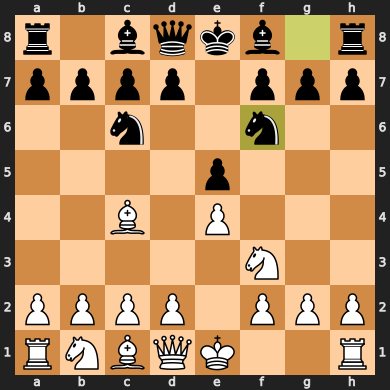

In [6]:
board

In [7]:
def predict(baord: chess.Board):
    tokens_ids = position_tokenizer.encode(board)
    torch_input = torch.tensor(tokens_ids).unsqueeze(0).long()  # Add batch dimension

    is_white = board.turn
    is_white = torch.tensor([is_white]).bool()  # Add batch dimension

    with torch.no_grad():
        logits = model(torch_input, is_white)

    legal_moves = [m.uci() for m in board.legal_moves]

    mask = torch.full((logits.size(-1),), float('-inf'))
    for move in legal_moves:
        move_id = move_tokenizer.encode(move)
        mask[move_id] = 0.0

    masked_logits = logits[0] + mask  # Assuming batch size of 1
    probs = torch.softmax(masked_logits, dim=-1)
    predicted_move_id = torch.argmax(probs).item()
    proba = probs[predicted_move_id].item()
    print(f"Predicted move id: {predicted_move_id} with probability {proba:.4f}")

    predicted_move = move_tokenizer.decode(predicted_move_id)

    print(f"Predicted move: {predicted_move}")
    print(f"Legal moves: {legal_moves}")

    return predicted_move, proba

predicted_move, proba = predict(board)
print(f"Predicted move: {predicted_move} with probability {proba:.4f}")

Predicted move id: 1345 with probability 0.4642
Predicted move: f3g5
Legal moves: ['c4f7', 'c4e6', 'c4a6', 'c4d5', 'c4b5', 'c4d3', 'c4b3', 'c4e2', 'c4f1', 'f3g5', 'f3e5', 'f3h4', 'f3d4', 'f3g1', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'h2h3', 'g2g3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'd2d4', 'b2b4', 'a2a4']
Predicted move: f3g5 with probability 0.4642


Predicted move id: 1345 with probability 0.4642
Predicted move: f3g5
Legal moves: ['c4f7', 'c4e6', 'c4a6', 'c4d5', 'c4b5', 'c4d3', 'c4b3', 'c4e2', 'c4f1', 'f3g5', 'f3e5', 'f3h4', 'f3d4', 'f3g1', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'h2h3', 'g2g3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'd2d4', 'b2b4', 'a2a4']


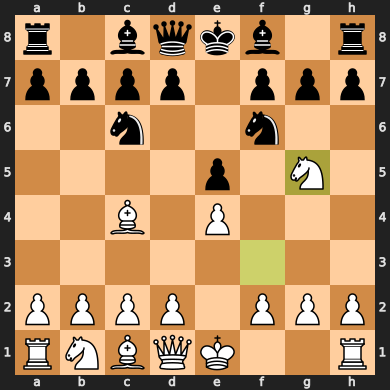



Predicted move id: 936 with probability 0.7390
Predicted move: d7d5
Legal moves: ['h8g8', 'f8e7', 'f8d6', 'f8c5', 'f8b4', 'f8a3', 'e8e7', 'd8e7', 'a8b8', 'f6g8', 'f6h5', 'f6d5', 'f6g4', 'f6e4', 'c6b8', 'c6e7', 'c6a5', 'c6d4', 'c6b4', 'h7h6', 'g7g6', 'd7d6', 'b7b6', 'a7a6', 'h7h5', 'd7d5', 'b7b5', 'a7a5']


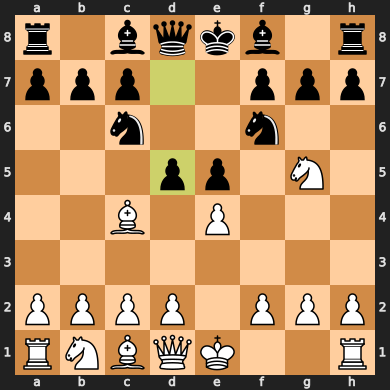



Predicted move id: 1096 with probability 0.9774
Predicted move: e4d5
Legal moves: ['g5h7', 'g5f7', 'g5e6', 'g5h3', 'g5f3', 'c4a6', 'c4d5', 'c4b5', 'c4d3', 'c4b3', 'c4e2', 'c4f1', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'e4d5', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'b2b4', 'a2a4']


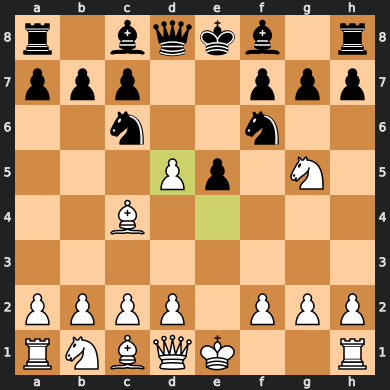



Predicted move id: 618 with probability 0.6076
Predicted move: c6a5
Legal moves: ['h8g8', 'f8e7', 'f8d6', 'f8c5', 'f8b4', 'f8a3', 'e8e7', 'e8d7', 'd8e7', 'd8d7', 'd8d6', 'd8d5', 'c8d7', 'c8e6', 'c8f5', 'c8g4', 'c8h3', 'a8b8', 'f6g8', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'f6e4', 'c6b8', 'c6e7', 'c6a5', 'c6d4', 'c6b4', 'h7h6', 'g7g6', 'b7b6', 'a7a6', 'e5e4', 'h7h5', 'b7b5', 'a7a5']


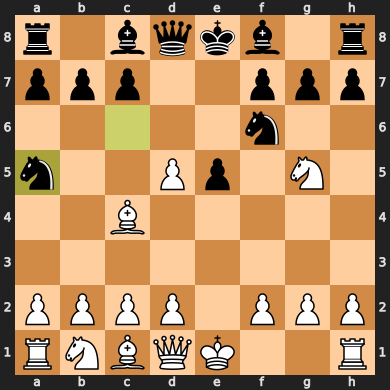



Predicted move id: 559 with probability 0.8226
Predicted move: c4b5
Legal moves: ['g5h7', 'g5f7', 'g5e6', 'g5e4', 'g5h3', 'g5f3', 'c4a6', 'c4b5', 'c4d3', 'c4b3', 'c4e2', 'c4f1', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'd5d6', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'b2b4', 'a2a4']


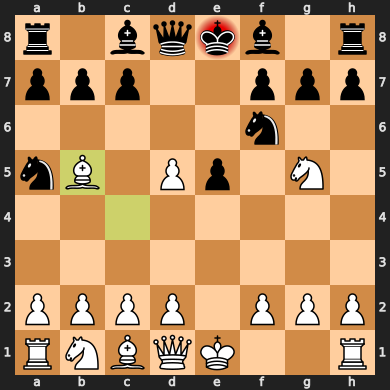



Predicted move id: 667 with probability 0.8116
Predicted move: c7c6
Legal moves: ['e8e7', 'd8d7', 'c8d7', 'f6d7', 'a5c6', 'c7c6']


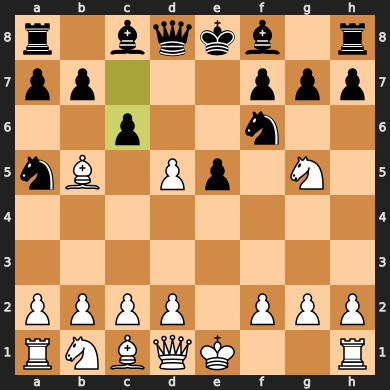



Predicted move id: 861 with probability 0.9686
Predicted move: d5c6
Legal moves: ['g5h7', 'g5f7', 'g5e6', 'g5e4', 'g5h3', 'g5f3', 'b5c6', 'b5a6', 'b5c4', 'b5a4', 'b5d3', 'b5e2', 'b5f1', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'd5c6', 'd5d6', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']


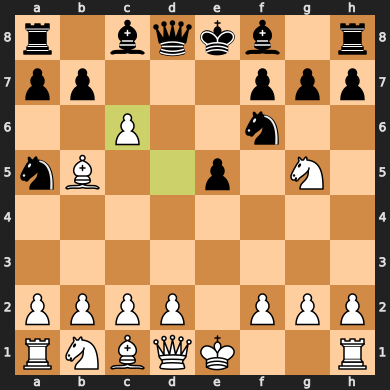



Predicted move id: 409 with probability 0.9386
Predicted move: b7c6
Legal moves: ['h8g8', 'f8e7', 'f8d6', 'f8c5', 'f8b4', 'f8a3', 'e8e7', 'd8e7', 'd8d7', 'd8c7', 'd8d6', 'd8b6', 'd8d5', 'd8d4', 'd8d3', 'd8d2', 'c8d7', 'c8e6', 'c8f5', 'c8g4', 'c8h3', 'a8b8', 'f6g8', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'f6e4', 'a5c6', 'a5c4', 'a5b3', 'b7c6', 'h7h6', 'g7g6', 'b7b6', 'a7a6', 'e5e4', 'h7h5']


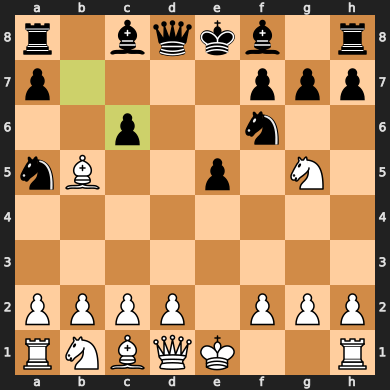



Predicted move id: 332 with probability 0.4429
Predicted move: b5a4
Legal moves: ['g5h7', 'g5f7', 'g5e6', 'g5e4', 'g5h3', 'g5f3', 'b5c6', 'b5a6', 'b5c4', 'b5a4', 'b5d3', 'b5e2', 'b5f1', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']


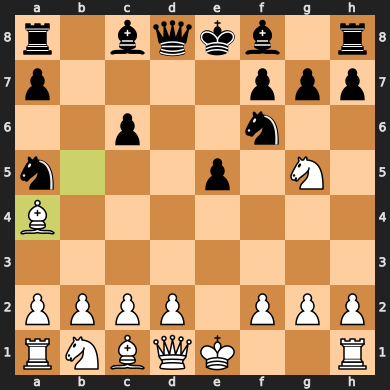



Predicted move id: 1939 with probability 0.2866
Predicted move: h7h6
Legal moves: ['h8g8', 'f8e7', 'f8d6', 'f8c5', 'f8b4', 'f8a3', 'e8e7', 'e8d7', 'd8e7', 'd8d7', 'd8c7', 'd8d6', 'd8b6', 'd8d5', 'd8d4', 'd8d3', 'd8d2', 'c8d7', 'c8b7', 'c8e6', 'c8a6', 'c8f5', 'c8g4', 'c8h3', 'a8b8', 'f6g8', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'f6e4', 'a5b7', 'a5c4', 'a5b3', 'h7h6', 'g7g6', 'a7a6', 'e5e4', 'h7h5']


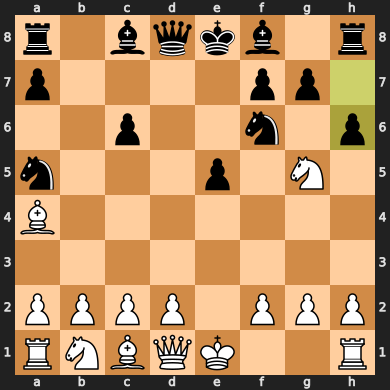



Predicted move id: 1649 with probability 0.5176
Predicted move: g5f3
Legal moves: ['g5h7', 'g5f7', 'g5e6', 'g5e4', 'g5h3', 'g5f3', 'a4c6', 'a4b5', 'a4b3', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'c2c4', 'b2b4']


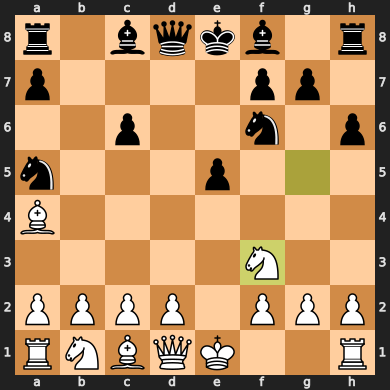



Predicted move id: 1136 with probability 0.3656
Predicted move: e5e4
Legal moves: ['h8g8', 'h8h7', 'f8e7', 'f8d6', 'f8c5', 'f8b4', 'f8a3', 'e8e7', 'e8d7', 'd8e7', 'd8d7', 'd8c7', 'd8d6', 'd8b6', 'd8d5', 'd8d4', 'd8d3', 'd8d2', 'c8d7', 'c8b7', 'c8e6', 'c8a6', 'c8f5', 'c8g4', 'c8h3', 'a8b8', 'f6g8', 'f6h7', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'f6e4', 'a5b7', 'a5c4', 'a5b3', 'g7g6', 'a7a6', 'h6h5', 'e5e4', 'g7g5']


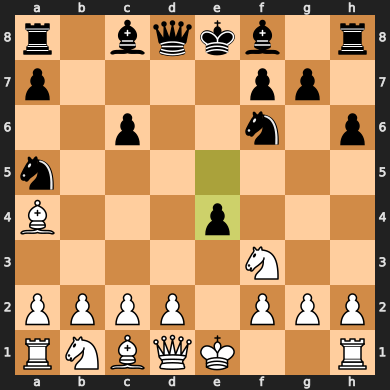



Predicted move id: 1333 with probability 0.6108
Predicted move: f3e5
Legal moves: ['a4c6', 'a4b5', 'a4b3', 'f3g5', 'f3e5', 'f3h4', 'f3d4', 'f3g1', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'h2h3', 'g2g3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'd2d4', 'c2c4', 'b2b4']


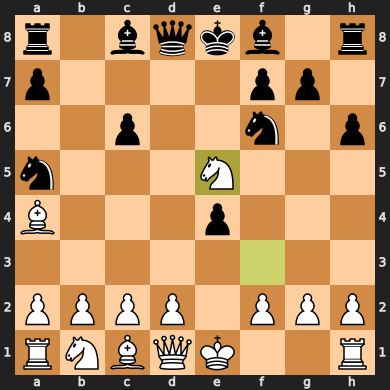



Predicted move id: 1497 with probability 0.3050
Predicted move: f8d6
Legal moves: ['h8g8', 'h8h7', 'f8e7', 'f8d6', 'f8c5', 'f8b4', 'f8a3', 'e8e7', 'd8e7', 'd8d7', 'd8c7', 'd8d6', 'd8b6', 'd8d5', 'd8d4', 'd8d3', 'd8d2', 'c8d7', 'c8b7', 'c8e6', 'c8a6', 'c8f5', 'c8g4', 'c8h3', 'a8b8', 'f6g8', 'f6h7', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'a5b7', 'a5c4', 'a5b3', 'g7g6', 'a7a6', 'h6h5', 'e4e3', 'g7g5']


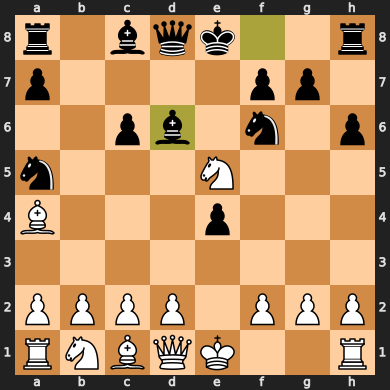



Predicted move id: 1126 with probability 0.3291
Predicted move: e5c6
Legal moves: ['e5f7', 'e5d7', 'e5g6', 'e5c6', 'e5g4', 'e5c4', 'e5f3', 'e5d3', 'a4c6', 'a4b5', 'a4b3', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'c2c4', 'b2b4']


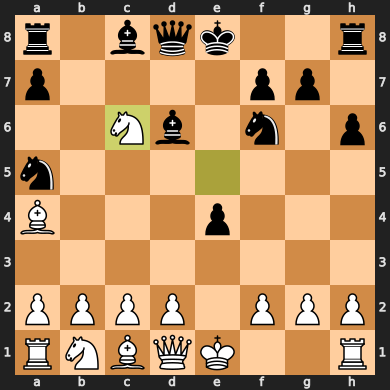



Predicted move id: 120 with probability 0.6759
Predicted move: a5c6
Legal moves: ['h8g8', 'h8f8', 'h8h7', 'e8f8', 'e8d7', 'd8e7', 'd8d7', 'd8c7', 'd8b6', 'c8d7', 'c8b7', 'c8e6', 'c8a6', 'c8f5', 'c8g4', 'c8h3', 'a8b8', 'f6g8', 'f6h7', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'd6f8', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'a5b7', 'a5c6', 'a5c4', 'a5b3', 'e8g8', 'g7g6', 'a7a6', 'h6h5', 'e4e3', 'g7g5']


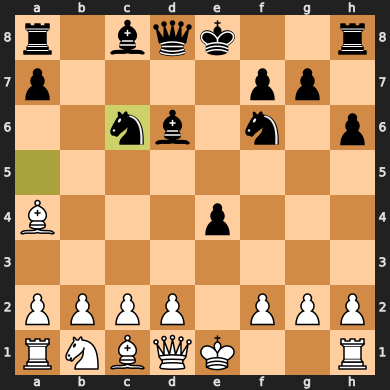



Predicted move id: 1004 with probability 0.5490
Predicted move: e1g1
Legal moves: ['a4c6', 'a4b5', 'a4b3', 'h1g1', 'h1f1', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'e1g1', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'c2c4', 'b2b4']


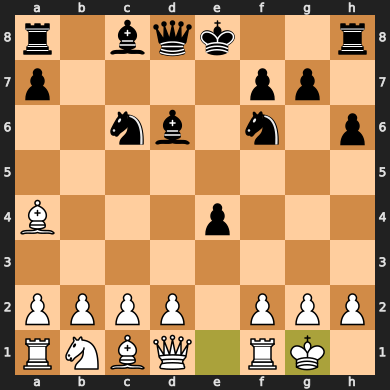



Predicted move id: 1249 with probability 0.6724
Predicted move: e8g8
Legal moves: ['h8g8', 'h8f8', 'h8h7', 'e8f8', 'e8e7', 'e8d7', 'd8e7', 'd8d7', 'd8c7', 'd8b6', 'd8a5', 'c8d7', 'c8b7', 'c8e6', 'c8a6', 'c8f5', 'c8g4', 'c8h3', 'a8b8', 'f6g8', 'f6h7', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'd6f8', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'e8g8', 'g7g6', 'a7a6', 'h6h5', 'e4e3', 'g7g5', 'a7a5']


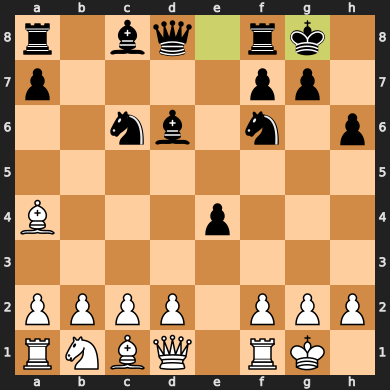



Predicted move id: 1261 with probability 0.2124
Predicted move: f1e1
Legal moves: ['a4c6', 'a4b5', 'a4b3', 'g1h1', 'f1e1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'd1e1', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'c2c4', 'b2b4']


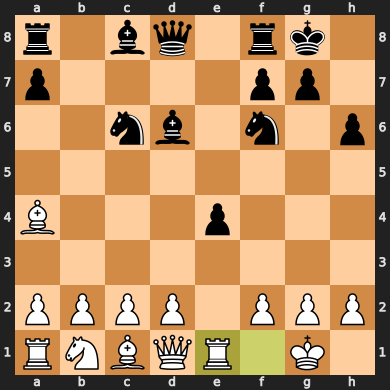



Predicted move id: 695 with probability 0.2122
Predicted move: c8b7
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'd8e8', 'd8e7', 'd8d7', 'd8c7', 'd8b6', 'd8a5', 'c8d7', 'c8b7', 'c8e6', 'c8a6', 'c8f5', 'c8g4', 'c8h3', 'a8b8', 'f6e8', 'f6h7', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'c6b8', 'c6e7', 'c6e5', 'c6a5', 'c6d4', 'c6b4', 'g7g6', 'a7a6', 'h6h5', 'e4e3', 'g7g5', 'a7a5']


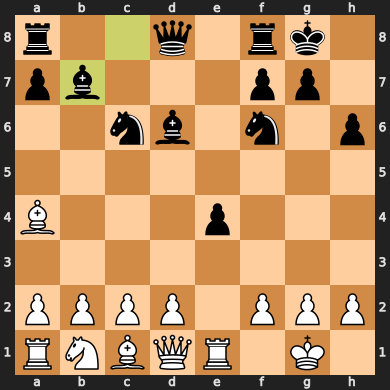



Predicted move id: 222 with probability 0.2283
Predicted move: b1c3
Legal moves: ['a4c6', 'a4b5', 'a4b3', 'g1h1', 'g1f1', 'e1e4', 'e1e3', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'c2c4', 'b2b4']


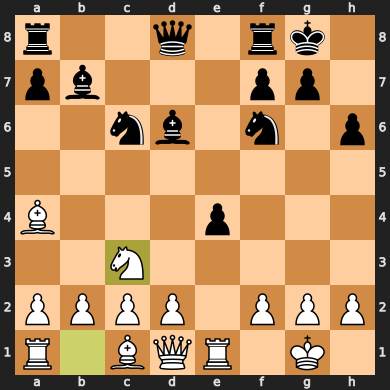



Predicted move id: 634 with probability 0.2141
Predicted move: c6d4
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'd8e8', 'd8c8', 'd8b8', 'd8e7', 'd8d7', 'd8c7', 'd8b6', 'd8a5', 'a8c8', 'a8b8', 'b7c8', 'b7a6', 'f6e8', 'f6h7', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'c6b8', 'c6e7', 'c6e5', 'c6a5', 'c6d4', 'c6b4', 'g7g6', 'a7a6', 'h6h5', 'e4e3', 'g7g5', 'a7a5']


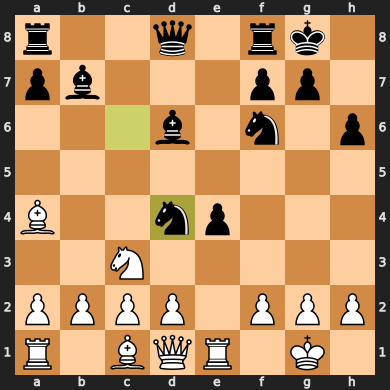



Predicted move id: 543 with probability 0.4114
Predicted move: c3e4
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'c3d5', 'c3b5', 'c3e4', 'c3e2', 'c3b1', 'g1h1', 'g1f1', 'e1e4', 'e1e3', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'a1b1', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'b2b4']


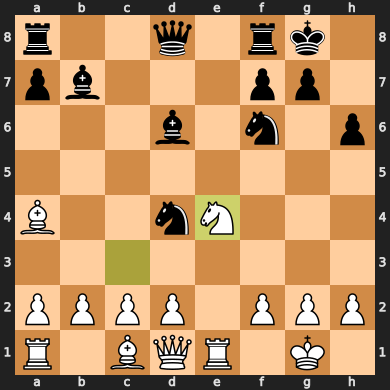



Predicted move id: 1428 with probability 0.8139
Predicted move: f6e4
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'd8e8', 'd8c8', 'd8b8', 'd8e7', 'd8d7', 'd8c7', 'd8b6', 'd8a5', 'a8c8', 'a8b8', 'b7c8', 'b7c6', 'b7a6', 'b7d5', 'b7e4', 'f6e8', 'f6h7', 'f6d7', 'f6h5', 'f6d5', 'f6g4', 'f6e4', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'd4e6', 'd4c6', 'd4f5', 'd4b5', 'd4f3', 'd4b3', 'd4e2', 'd4c2', 'g7g6', 'a7a6', 'h6h5', 'g7g5', 'a7a5']


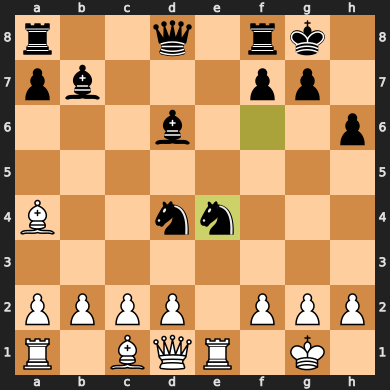



Predicted move id: 996 with probability 0.7082
Predicted move: e1e4
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'g1h1', 'g1f1', 'e1e4', 'e1e3', 'e1e2', 'e1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'a1b1', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'c2c4', 'b2b4']


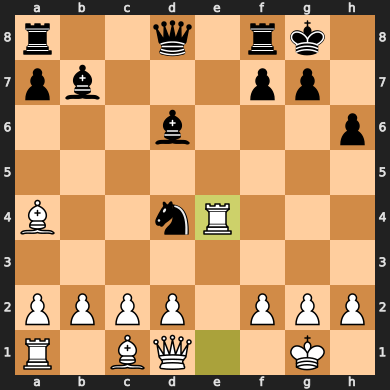



Predicted move id: 420 with probability 0.5428
Predicted move: b7e4
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'd8e8', 'd8c8', 'd8b8', 'd8e7', 'd8d7', 'd8c7', 'd8f6', 'd8b6', 'd8g5', 'd8a5', 'd8h4', 'a8c8', 'a8b8', 'b7c8', 'b7c6', 'b7a6', 'b7d5', 'b7e4', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'd4e6', 'd4c6', 'd4f5', 'd4b5', 'd4f3', 'd4b3', 'd4e2', 'd4c2', 'g7g6', 'f7f6', 'a7a6', 'h6h5', 'g7g5', 'f7f5', 'a7a5']


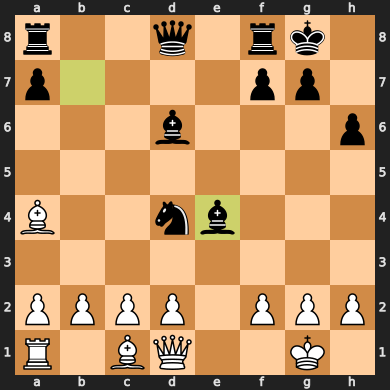



Predicted move id: 494 with probability 0.2864
Predicted move: c2c3
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'g1h1', 'g1f1', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'd1f1', 'd1e1', 'a1b1', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'c2c4', 'b2b4']


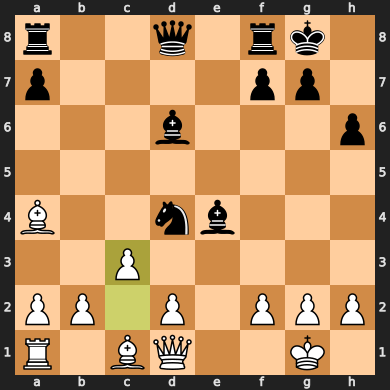



Predicted move id: 1110 with probability 0.1440
Predicted move: e4g2
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'd8e8', 'd8c8', 'd8b8', 'd8e7', 'd8d7', 'd8c7', 'd8f6', 'd8b6', 'd8g5', 'd8a5', 'd8h4', 'a8c8', 'a8b8', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'e4h7', 'e4b7', 'e4g6', 'e4c6', 'e4f5', 'e4d5', 'e4f3', 'e4d3', 'e4g2', 'e4c2', 'e4b1', 'd4e6', 'd4c6', 'd4f5', 'd4b5', 'd4f3', 'd4b3', 'd4e2', 'd4c2', 'g7g6', 'f7f6', 'a7a6', 'h6h5', 'g7g5', 'f7f5', 'a7a5']


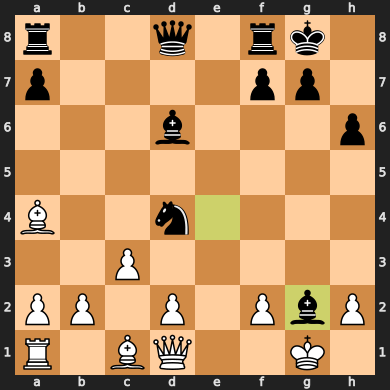



Predicted move id: 1530 with probability 0.2212
Predicted move: g1g2
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'a4c2', 'g1g2', 'd1h5', 'd1g4', 'd1f3', 'd1b3', 'd1e2', 'd1c2', 'd1f1', 'd1e1', 'a1b1', 'c3d4', 'c3c4', 'h2h3', 'f2f3', 'd2d3', 'b2b3', 'a2a3', 'h2h4', 'f2f4', 'b2b4']


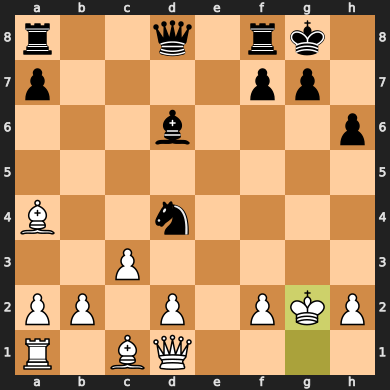



Predicted move id: 843 with probability 0.1309
Predicted move: d4f5
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'd8e8', 'd8c8', 'd8b8', 'd8e7', 'd8d7', 'd8c7', 'd8f6', 'd8b6', 'd8g5', 'd8a5', 'd8h4', 'a8c8', 'a8b8', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'd4e6', 'd4c6', 'd4f5', 'd4b5', 'd4f3', 'd4b3', 'd4e2', 'd4c2', 'g7g6', 'f7f6', 'a7a6', 'h6h5', 'g7g5', 'f7f5', 'a7a5']


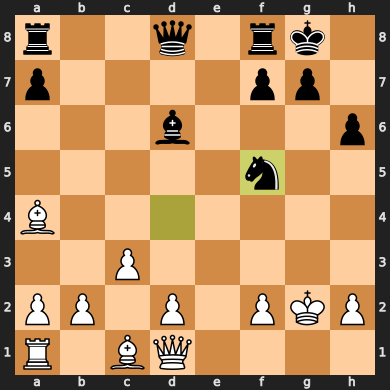



Predicted move id: 761 with probability 0.2438
Predicted move: d2d4
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'a4c2', 'g2h3', 'g2f3', 'g2h1', 'g2g1', 'g2f1', 'd1h5', 'd1g4', 'd1f3', 'd1b3', 'd1e2', 'd1c2', 'd1h1', 'd1g1', 'd1f1', 'd1e1', 'a1b1', 'c3c4', 'h2h3', 'f2f3', 'd2d3', 'b2b3', 'a2a3', 'h2h4', 'f2f4', 'd2d4', 'b2b4']


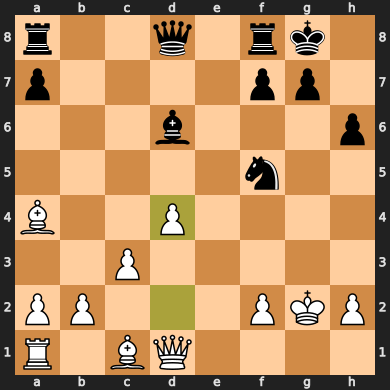



Predicted move id: 982 with probability 0.1435
Predicted move: d8h4
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'd8e8', 'd8c8', 'd8b8', 'd8e7', 'd8d7', 'd8c7', 'd8f6', 'd8b6', 'd8g5', 'd8a5', 'd8h4', 'a8c8', 'a8b8', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'f5e7', 'f5h4', 'f5d4', 'f5g3', 'f5e3', 'g7g6', 'f7f6', 'a7a6', 'h6h5', 'g7g5', 'a7a5']


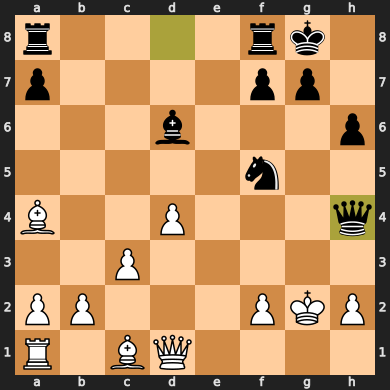



Predicted move id: 736 with probability 0.1626
Predicted move: d1f3
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'a4c2', 'g2f3', 'g2h1', 'g2g1', 'g2f1', 'd1h5', 'd1g4', 'd1f3', 'd1d3', 'd1b3', 'd1e2', 'd1d2', 'd1c2', 'd1h1', 'd1g1', 'd1f1', 'd1e1', 'c1h6', 'c1g5', 'c1f4', 'c1e3', 'c1d2', 'a1b1', 'd4d5', 'c3c4', 'h2h3', 'f2f3', 'b2b3', 'a2a3', 'f2f4', 'b2b4']


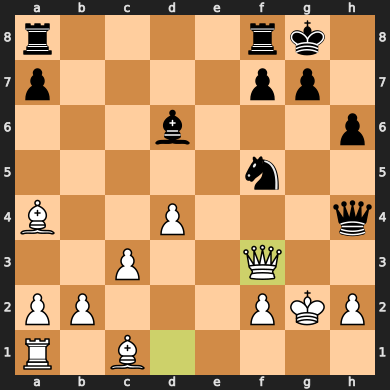



Predicted move id: 1407 with probability 0.2267
Predicted move: f5g3
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'f8d8', 'f8c8', 'f8b8', 'a8e8', 'a8d8', 'a8c8', 'a8b8', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'd6h2', 'f5e7', 'f5d4', 'f5g3', 'f5e3', 'h4d8', 'h4e7', 'h4f6', 'h4h5', 'h4g5', 'h4g4', 'h4f4', 'h4e4', 'h4d4', 'h4h3', 'h4g3', 'h4h2', 'h4f2', 'g7g6', 'f7f6', 'a7a6', 'h6h5', 'g7g5', 'a7a5']


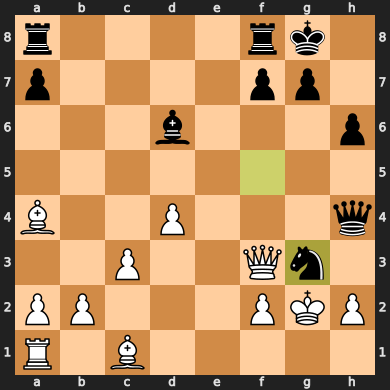



Predicted move id: 1343 with probability 0.2735
Predicted move: f3g3
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'a4c2', 'a4d1', 'f3a8', 'f3f7', 'f3b7', 'f3f6', 'f3c6', 'f3h5', 'f3f5', 'f3d5', 'f3g4', 'f3f4', 'f3e4', 'f3g3', 'f3e3', 'f3d3', 'f3e2', 'f3d1', 'g2g1', 'c1h6', 'c1g5', 'c1f4', 'c1e3', 'c1d2', 'a1b1', 'h2g3', 'f2g3', 'd4d5', 'c3c4', 'h2h3', 'b2b3', 'a2a3', 'b2b4']


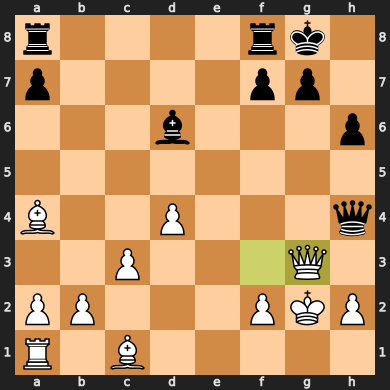



Predicted move id: 914 with probability 0.2653
Predicted move: d6g3
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'f8d8', 'f8c8', 'f8b8', 'a8e8', 'a8d8', 'a8c8', 'a8b8', 'd6b8', 'd6e7', 'd6c7', 'd6e5', 'd6c5', 'd6f4', 'd6b4', 'd6g3', 'd6a3', 'h4d8', 'h4e7', 'h4f6', 'h4h5', 'h4g5', 'h4g4', 'h4f4', 'h4e4', 'h4d4', 'h4h3', 'h4g3', 'h4h2', 'g7g6', 'f7f6', 'a7a6', 'h6h5', 'g7g5', 'f7f5', 'a7a5']


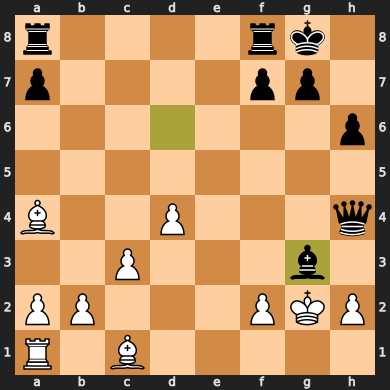



Predicted move id: 1312 with probability 0.1576
Predicted move: f2g3
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'a4c2', 'a4d1', 'g2f3', 'g2h1', 'g2g1', 'g2f1', 'c1h6', 'c1g5', 'c1f4', 'c1e3', 'c1d2', 'a1b1', 'h2g3', 'f2g3', 'd4d5', 'c3c4', 'h2h3', 'f2f3', 'b2b3', 'a2a3', 'f2f4', 'b2b4']


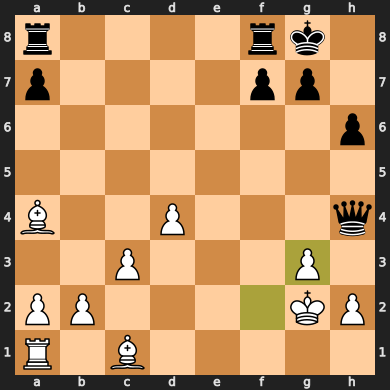



Predicted move id: 1853 with probability 0.1076
Predicted move: h4g4
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'f8d8', 'f8c8', 'f8b8', 'a8e8', 'a8d8', 'a8c8', 'a8b8', 'h4d8', 'h4e7', 'h4f6', 'h4h5', 'h4g5', 'h4g4', 'h4f4', 'h4e4', 'h4d4', 'h4h3', 'h4g3', 'h4h2', 'g7g6', 'f7f6', 'a7a6', 'h6h5', 'g7g5', 'f7f5', 'a7a5']


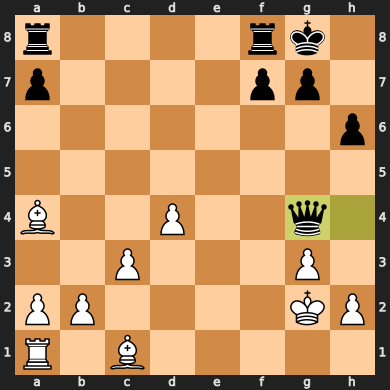



Predicted move id: 88 with probability 0.1529
Predicted move: a4b3
Legal moves: ['a4e8', 'a4d7', 'a4c6', 'a4b5', 'a4b3', 'a4c2', 'a4d1', 'g2f2', 'g2h1', 'g2g1', 'g2f1', 'c1h6', 'c1g5', 'c1f4', 'c1e3', 'c1d2', 'a1b1', 'd4d5', 'c3c4', 'h2h3', 'b2b3', 'a2a3', 'h2h4', 'b2b4']


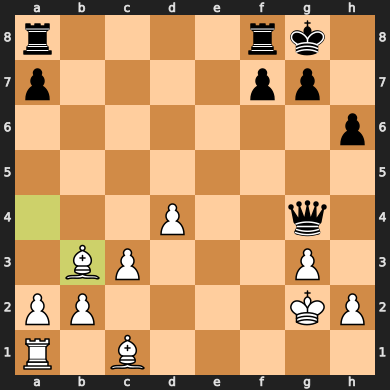



Predicted move id: 1502 with probability 0.1563
Predicted move: f8e8
Legal moves: ['g8h8', 'g8h7', 'f8e8', 'f8d8', 'f8c8', 'f8b8', 'a8e8', 'a8d8', 'a8c8', 'a8b8', 'g4c8', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'g7g6', 'a7a6', 'h6h5', 'g7g5', 'a7a5']


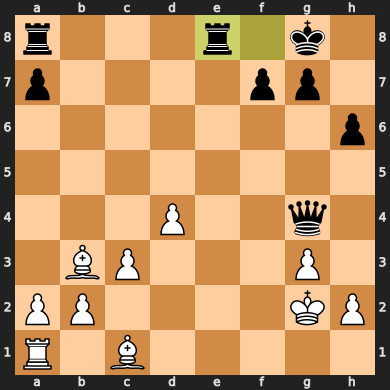



Predicted move id: 472 with probability 0.3502
Predicted move: c1f4
Legal moves: ['b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'g2f2', 'g2h1', 'g2g1', 'g2f1', 'c1h6', 'c1g5', 'c1f4', 'c1e3', 'c1d2', 'a1b1', 'd4d5', 'c3c4', 'h2h3', 'a2a3', 'h2h4', 'a2a4']


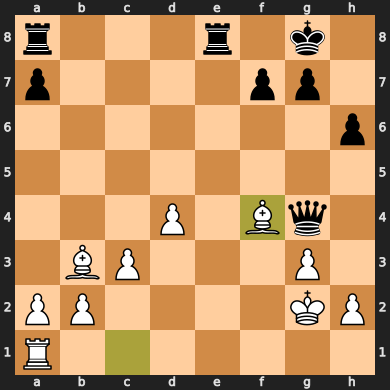



Predicted move id: 201 with probability 0.2188
Predicted move: a8d8
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'e8f8', 'e8d8', 'e8c8', 'e8b8', 'e8e7', 'e8e6', 'e8e5', 'e8e4', 'e8e3', 'e8e2', 'e8e1', 'a8d8', 'a8c8', 'a8b8', 'g4c8', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'g7g6', 'a7a6', 'h6h5', 'g7g5', 'a7a5']


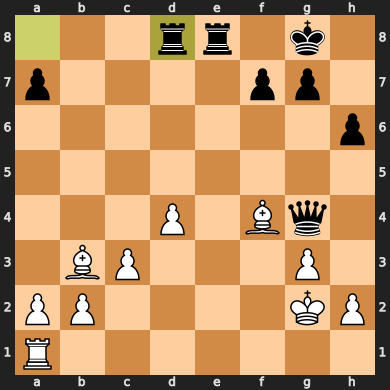



Predicted move id: 15 with probability 0.1670
Predicted move: a1e1
Legal moves: ['f4b8', 'f4c7', 'f4h6', 'f4d6', 'f4g5', 'f4e5', 'f4e3', 'f4d2', 'f4c1', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'g2f2', 'g2h1', 'g2g1', 'g2f1', 'a1h1', 'a1g1', 'a1f1', 'a1e1', 'a1d1', 'a1c1', 'a1b1', 'd4d5', 'c3c4', 'h2h3', 'a2a3', 'h2h4', 'a2a4']


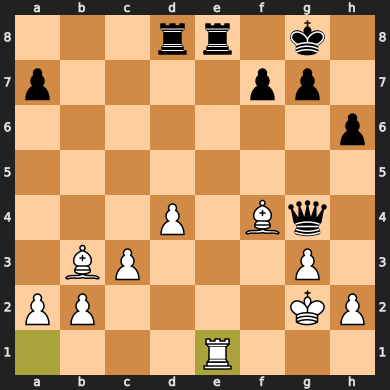



Predicted move id: 1237 with probability 0.3377
Predicted move: e8e1
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'e8f8', 'e8e7', 'e8e6', 'e8e5', 'e8e4', 'e8e3', 'e8e2', 'e8e1', 'd8c8', 'd8b8', 'd8a8', 'd8d7', 'd8d6', 'd8d5', 'd8d4', 'g4c8', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'g7g6', 'a7a6', 'h6h5', 'g7g5', 'a7a5']


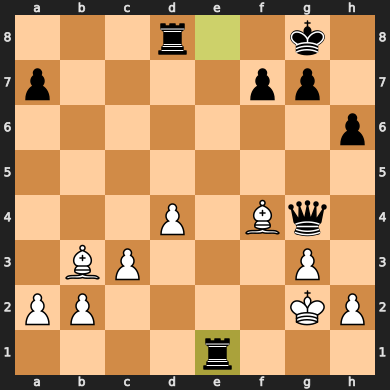



Predicted move id: 1557 with probability 0.2278
Predicted move: g2f2
Legal moves: ['f4b8', 'f4c7', 'f4h6', 'f4d6', 'f4g5', 'f4e5', 'f4e3', 'f4d2', 'f4c1', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'g2f2', 'd4d5', 'c3c4', 'h2h3', 'a2a3', 'h2h4', 'a2a4']


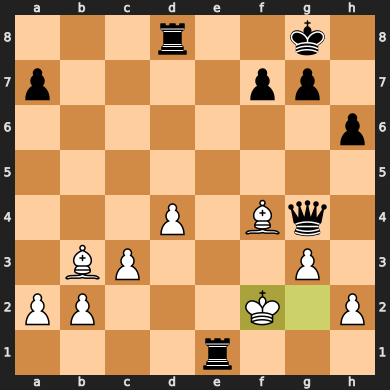



Predicted move id: 1001 with probability 0.2123
Predicted move: e1f1
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'd8f8', 'd8e8', 'd8c8', 'd8b8', 'd8a8', 'd8d7', 'd8d6', 'd8d5', 'd8d4', 'g4c8', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'g7g6', 'a7a6', 'h6h5', 'g7g5', 'a7a5']


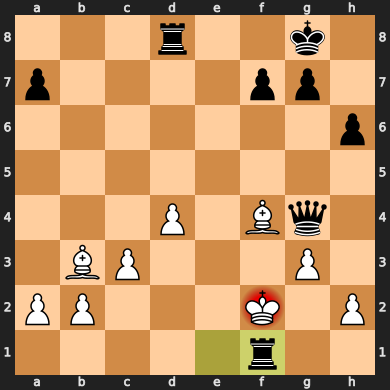



Predicted move id: 1295 with probability 0.5332
Predicted move: f2f1
Legal moves: ['f2e3', 'f2g2', 'f2f1']


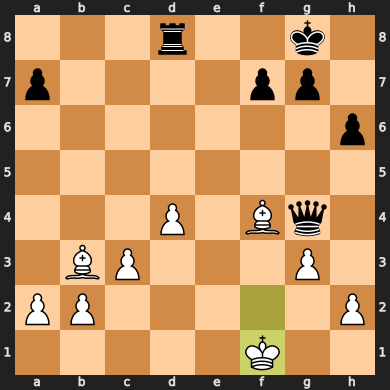



Predicted move id: 1719 with probability 0.1443
Predicted move: g7g5
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'd8f8', 'd8e8', 'd8c8', 'd8b8', 'd8a8', 'd8d7', 'd8d6', 'd8d5', 'd8d4', 'g4c8', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'g7g6', 'a7a6', 'h6h5', 'g7g5', 'a7a5']


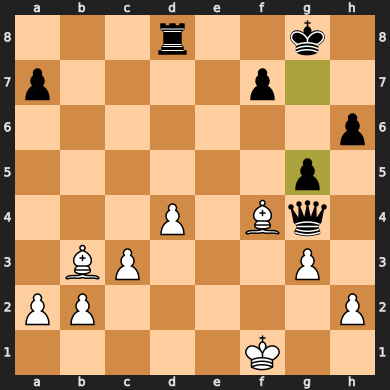



Predicted move id: 1363 with probability 0.2541
Predicted move: f4e3
Legal moves: ['f4b8', 'f4c7', 'f4d6', 'f4g5', 'f4e5', 'f4e3', 'f4d2', 'f4c1', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'f1g2', 'f1f2', 'f1g1', 'f1e1', 'd4d5', 'c3c4', 'h2h3', 'a2a3', 'h2h4', 'a2a4']


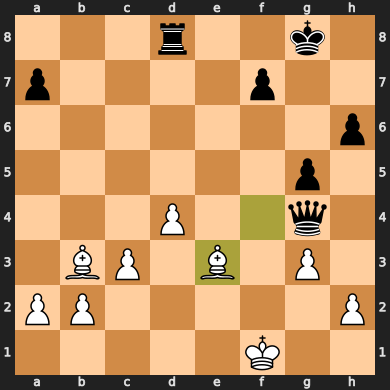



Predicted move id: 1910 with probability 0.2264
Predicted move: h6h5
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'd8f8', 'd8e8', 'd8c8', 'd8b8', 'd8a8', 'd8d7', 'd8d6', 'd8d5', 'd8d4', 'g4c8', 'g4d7', 'g4e6', 'g4h5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'a7a6', 'h6h5', 'a7a5']


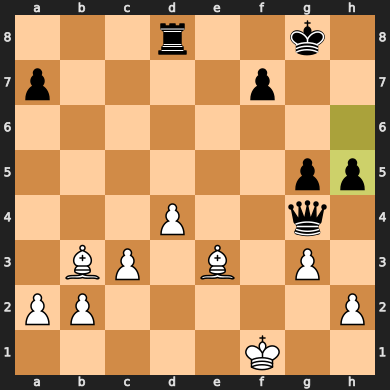



Predicted move id: 1080 with probability 0.1368
Predicted move: e3g5
Legal moves: ['e3g5', 'e3f4', 'e3f2', 'e3d2', 'e3g1', 'e3c1', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'f1g2', 'f1f2', 'f1g1', 'f1e1', 'd4d5', 'c3c4', 'h2h3', 'a2a3', 'h2h4', 'a2a4']


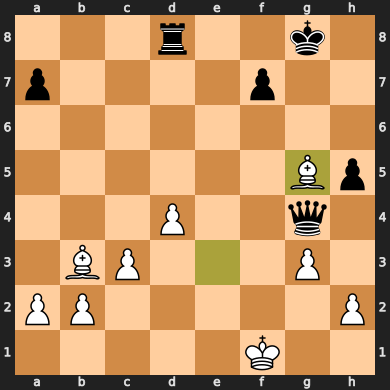



Predicted move id: 976 with probability 0.1913
Predicted move: d8e8
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'd8f8', 'd8e8', 'd8c8', 'd8b8', 'd8a8', 'd8d7', 'd8d6', 'd8d5', 'd8d4', 'g4c8', 'g4d7', 'g4e6', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'a7a6', 'h5h4', 'a7a5']


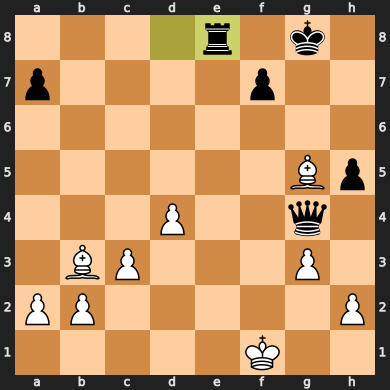



Predicted move id: 1644 with probability 0.1224
Predicted move: g5e3
Legal moves: ['g5d8', 'g5e7', 'g5h6', 'g5f6', 'g5h4', 'g5f4', 'g5e3', 'g5d2', 'g5c1', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'f1g2', 'f1f2', 'f1g1', 'd4d5', 'c3c4', 'h2h3', 'a2a3', 'h2h4', 'a2a4']


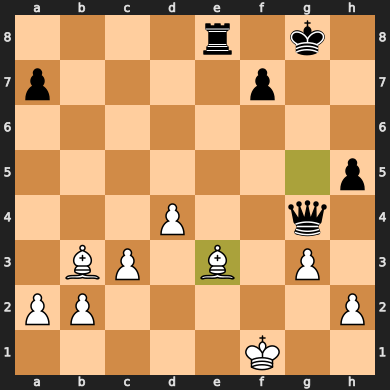



Predicted move id: 1239 with probability 0.3910
Predicted move: e8e3
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'e8f8', 'e8d8', 'e8c8', 'e8b8', 'e8a8', 'e8e7', 'e8e6', 'e8e5', 'e8e4', 'e8e3', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'a7a6', 'h5h4', 'a7a5']


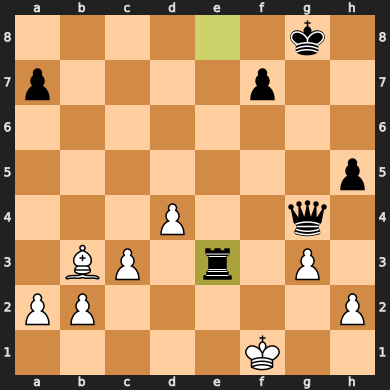



Predicted move id: 286 with probability 0.2493
Predicted move: b3c2
Legal moves: ['b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'f1g2', 'f1f2', 'f1g1', 'd4d5', 'c3c4', 'h2h3', 'a2a3', 'h2h4', 'a2a4']


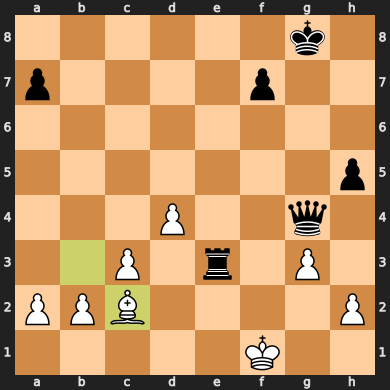



Predicted move id: 1078 with probability 0.1676
Predicted move: e3g3
Legal moves: ['g8h8', 'g8f8', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'e3e8', 'e3e7', 'e3e6', 'e3e5', 'e3e4', 'e3g3', 'e3f3', 'e3d3', 'e3c3', 'e3e2', 'e3e1', 'f7f6', 'a7a6', 'h5h4', 'f7f5', 'a7a5']


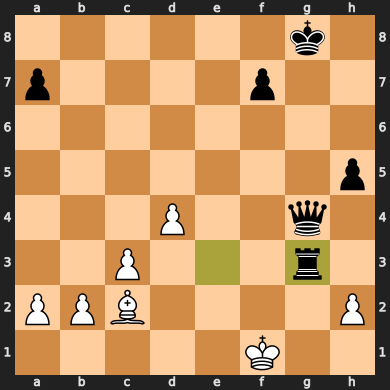



Predicted move id: 500 with probability 0.2709
Predicted move: c2d1
Legal moves: ['c2h7', 'c2g6', 'c2f5', 'c2e4', 'c2a4', 'c2d3', 'c2b3', 'c2d1', 'c2b1', 'f1f2', 'f1e1', 'h2g3', 'd4d5', 'c3c4', 'h2h3', 'b2b3', 'a2a3', 'h2h4', 'b2b4', 'a2a4']


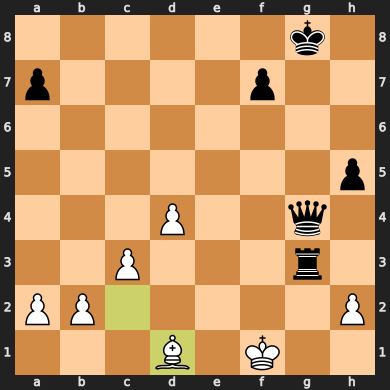



Predicted move id: 1884 with probability 0.5619
Predicted move: h5h4
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4f3', 'g4e2', 'g4d1', 'g3h3', 'g3f3', 'g3e3', 'g3d3', 'g3c3', 'g3g2', 'g3g1', 'f7f6', 'a7a6', 'h5h4', 'f7f5', 'a7a5']


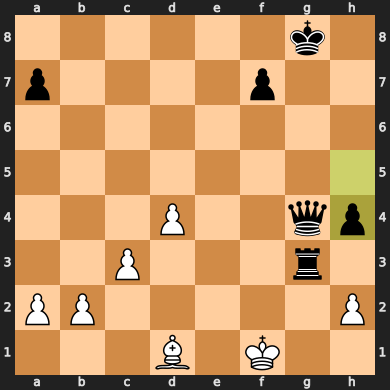



Predicted move id: 732 with probability 0.2544
Predicted move: d1e2
Legal moves: ['f1f2', 'f1e1', 'd1g4', 'd1a4', 'd1f3', 'd1b3', 'd1e2', 'd1c2', 'h2g3', 'd4d5', 'c3c4', 'h2h3', 'b2b3', 'a2a3', 'b2b4', 'a2a4']


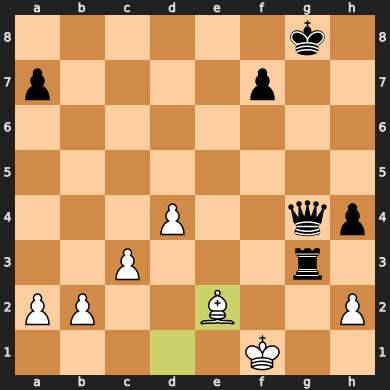



Predicted move id: 1858 with probability 0.5870
Predicted move: h4h3
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4f3', 'g4e2', 'g3h3', 'g3f3', 'g3e3', 'g3d3', 'g3c3', 'g3g2', 'g3g1', 'f7f6', 'a7a6', 'h4h3', 'f7f5', 'a7a5']


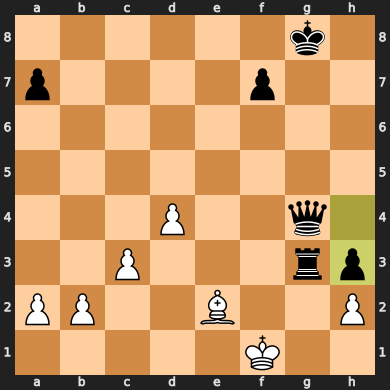



Predicted move id: 1264 with probability 0.2069
Predicted move: f1f2
Legal moves: ['e2a6', 'e2b5', 'e2g4', 'e2c4', 'e2f3', 'e2d3', 'e2d1', 'f1f2', 'f1e1', 'h2g3', 'd4d5', 'c3c4', 'b2b3', 'a2a3', 'b2b4', 'a2a4']


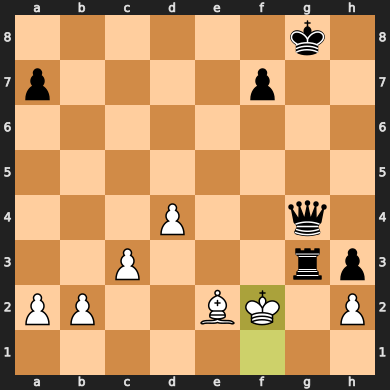



Predicted move id: 1597 with probability 0.3670
Predicted move: g3g2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4f3', 'g4e2', 'g3f3', 'g3e3', 'g3d3', 'g3c3', 'g3g2', 'g3g1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


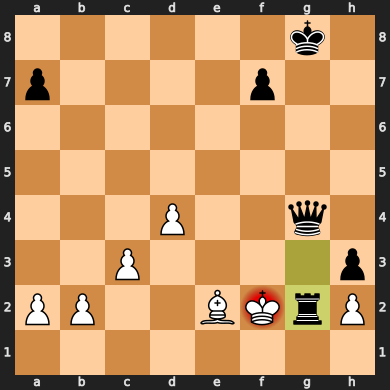



Predicted move id: 1287 with probability 0.5224
Predicted move: f2e1
Legal moves: ['f2e3', 'f2f1', 'f2e1']


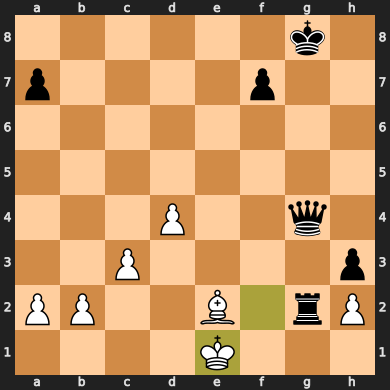



Predicted move id: 1576 with probability 0.1436
Predicted move: g2h2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4g3', 'g4f3', 'g4e2', 'g2g3', 'g2h2', 'g2f2', 'g2e2', 'g2g1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


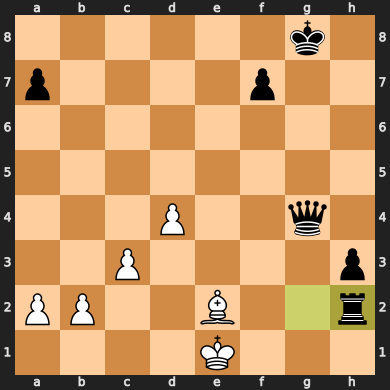



Predicted move id: 1017 with probability 0.1977
Predicted move: e2d1
Legal moves: ['e2a6', 'e2b5', 'e2g4', 'e2c4', 'e2f3', 'e2d3', 'e2f1', 'e2d1', 'e1d2', 'e1f1', 'e1d1', 'd4d5', 'c3c4', 'b2b3', 'a2a3', 'b2b4', 'a2a4']


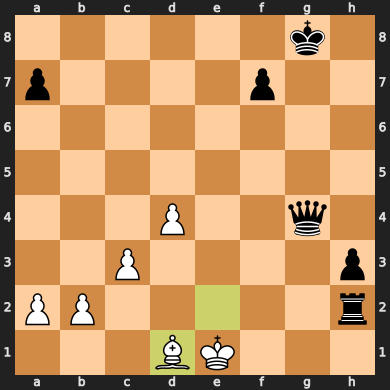



Predicted move id: 1802 with probability 0.1808
Predicted move: h2h1
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4g3', 'g4f3', 'g4g2', 'g4e2', 'g4g1', 'g4d1', 'h2g2', 'h2f2', 'h2e2', 'h2d2', 'h2c2', 'h2b2', 'h2h1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


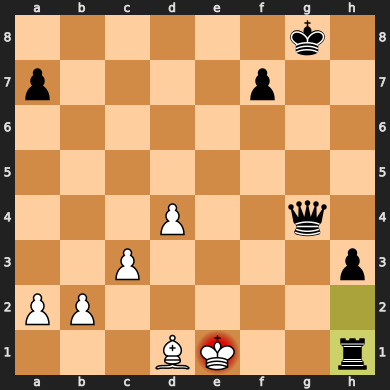



Predicted move id: 992 with probability 0.7227
Predicted move: e1d2
Legal moves: ['e1f2', 'e1d2']


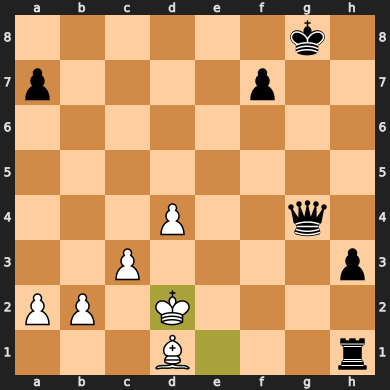



Predicted move id: 1768 with probability 0.2351
Predicted move: h1f1
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4g3', 'g4f3', 'g4g2', 'g4e2', 'g4g1', 'g4d1', 'h1h2', 'h1g1', 'h1f1', 'h1e1', 'h1d1', 'f7f6', 'a7a6', 'h3h2', 'f7f5', 'a7a5']


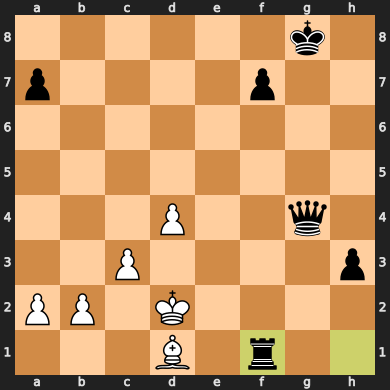



Predicted move id: 722 with probability 0.3627
Predicted move: d1c2
Legal moves: ['d2e3', 'd2d3', 'd2c2', 'd2c1', 'd1g4', 'd1a4', 'd1f3', 'd1b3', 'd1e2', 'd1c2', 'd4d5', 'c3c4', 'b2b3', 'a2a3', 'b2b4', 'a2a4']


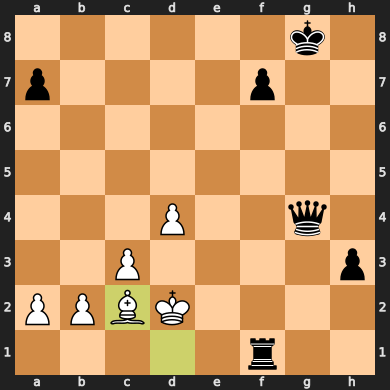



Predicted move id: 1832 with probability 0.1856
Predicted move: h3h2
Legal moves: ['g8h8', 'g8f8', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4g3', 'g4f3', 'g4g2', 'g4e2', 'g4g1', 'g4d1', 'f1f6', 'f1f5', 'f1f4', 'f1f3', 'f1f2', 'f1h1', 'f1g1', 'f1e1', 'f1d1', 'f1c1', 'f1b1', 'f1a1', 'f7f6', 'a7a6', 'h3h2', 'f7f5', 'a7a5']


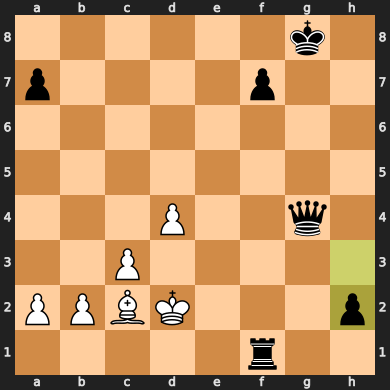



Predicted move id: 500 with probability 0.2595
Predicted move: c2d1
Legal moves: ['d2e3', 'd2d3', 'c2h7', 'c2g6', 'c2f5', 'c2e4', 'c2a4', 'c2d3', 'c2b3', 'c2d1', 'c2b1', 'd4d5', 'c3c4', 'b2b3', 'a2a3', 'b2b4', 'a2a4']


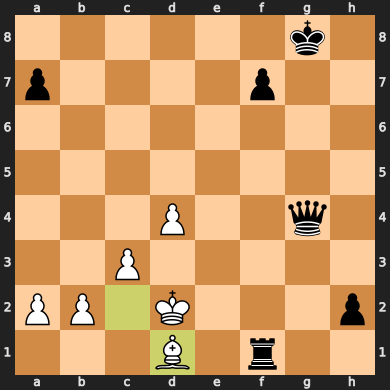



Predicted move id: 1271 with probability 0.1061
Predicted move: f1g1
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4g2', 'g4e2', 'g4g1', 'g4d1', 'f1f6', 'f1f5', 'f1f4', 'f1f3', 'f1f2', 'f1h1', 'f1g1', 'f1e1', 'f1d1', 'f7f6', 'a7a6', 'h2h1q', 'h2h1r', 'h2h1b', 'h2h1n', 'f7f5', 'a7a5']


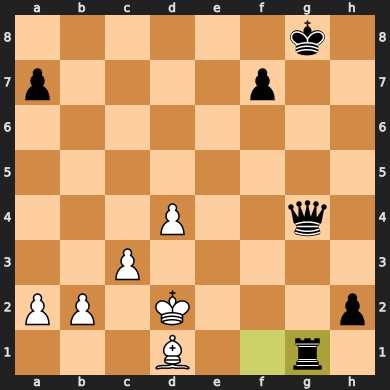



Predicted move id: 722 with probability 0.4164
Predicted move: d1c2
Legal moves: ['d2e3', 'd2d3', 'd2c2', 'd2c1', 'd1g4', 'd1a4', 'd1f3', 'd1b3', 'd1e2', 'd1c2', 'd4d5', 'c3c4', 'b2b3', 'a2a3', 'b2b4', 'a2a4']


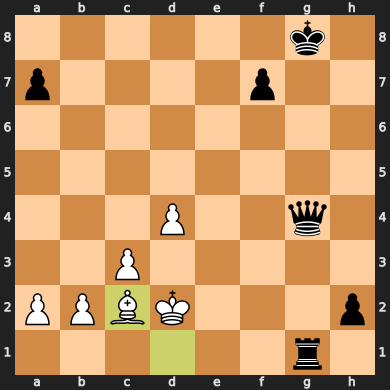



Predicted move id: 1805 with probability 0.1548
Predicted move: h2h1q
Legal moves: ['g8h8', 'g8f8', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4g2', 'g4e2', 'g4d1', 'g1g3', 'g1g2', 'g1h1', 'g1f1', 'g1e1', 'g1d1', 'g1c1', 'g1b1', 'g1a1', 'f7f6', 'a7a6', 'h2h1q', 'h2h1r', 'h2h1b', 'h2h1n', 'f7f5', 'a7a5']


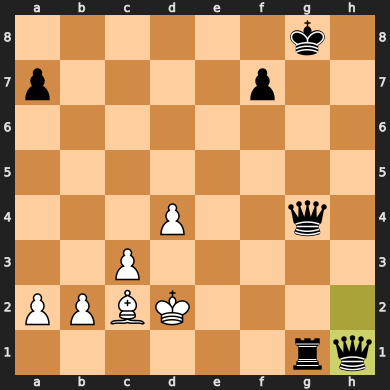



Predicted move id: 487 with probability 0.2874
Predicted move: c2b3
Legal moves: ['d2e3', 'd2d3', 'c2h7', 'c2g6', 'c2f5', 'c2e4', 'c2a4', 'c2d3', 'c2b3', 'c2d1', 'c2b1', 'd4d5', 'c3c4', 'b2b3', 'a2a3', 'b2b4', 'a2a4']


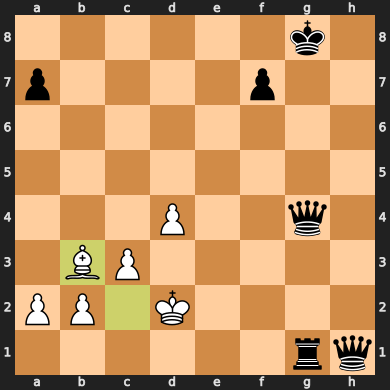



Predicted move id: 1772 with probability 0.1659
Predicted move: h1g2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4g2', 'g4e2', 'g4d1', 'h1h8', 'h1a8', 'h1h7', 'h1b7', 'h1h6', 'h1c6', 'h1h5', 'h1d5', 'h1h4', 'h1e4', 'h1h3', 'h1f3', 'h1h2', 'h1g2', 'g1g3', 'g1g2', 'g1f1', 'g1e1', 'g1d1', 'g1c1', 'g1b1', 'g1a1', 'a7a6', 'a7a5']


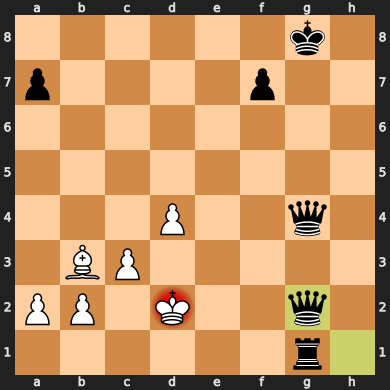



Predicted move id: 760 with probability 0.5699
Predicted move: d2d3
Legal moves: ['d2e3', 'd2d3']


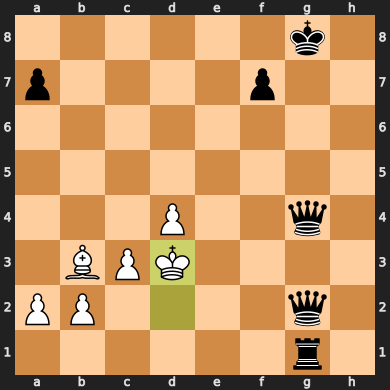



Predicted move id: 1612 with probability 0.0816
Predicted move: g4d1
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g4c8', 'g4g7', 'g4d7', 'g4g6', 'g4e6', 'g4h5', 'g4g5', 'g4f5', 'g4h4', 'g4f4', 'g4e4', 'g4d4', 'g4h3', 'g4g3', 'g4f3', 'g4e2', 'g4d1', 'g2a8', 'g2b7', 'g2c6', 'g2d5', 'g2e4', 'g2h3', 'g2g3', 'g2f3', 'g2h2', 'g2f2', 'g2e2', 'g2d2', 'g2c2', 'g2b2', 'g2h1', 'g2f1', 'g1h1', 'g1f1', 'g1e1', 'g1d1', 'g1c1', 'g1b1', 'g1a1', 'a7a6', 'a7a5']


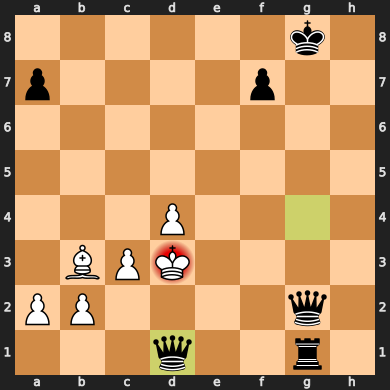



Predicted move id: 792 with probability 0.5514
Predicted move: d3c4
Legal moves: ['d3c4', 'd3e3', 'b3d1']


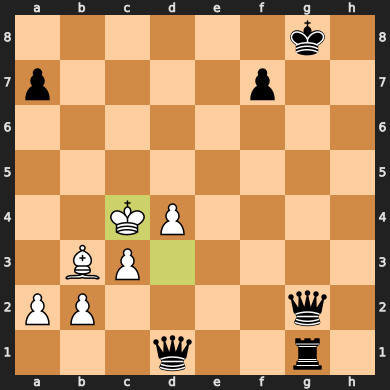



Predicted move id: 736 with probability 0.1040
Predicted move: d1f3
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g2a8', 'g2g7', 'g2b7', 'g2g6', 'g2c6', 'g2g5', 'g2d5', 'g2g4', 'g2e4', 'g2h3', 'g2g3', 'g2f3', 'g2h2', 'g2f2', 'g2e2', 'g2d2', 'g2c2', 'g2b2', 'g2h1', 'g2f1', 'g1h1', 'g1f1', 'g1e1', 'd1h5', 'd1g4', 'd1d4', 'd1f3', 'd1d3', 'd1b3', 'd1e2', 'd1d2', 'd1c2', 'd1f1', 'd1e1', 'd1c1', 'd1b1', 'd1a1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


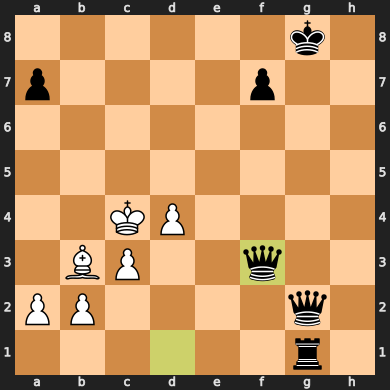



Predicted move id: 286 with probability 0.2850
Predicted move: b3c2
Legal moves: ['c4c5', 'c4b5', 'c4b4', 'b3a4', 'b3c2', 'b3d1', 'd4d5', 'a2a3', 'a2a4']


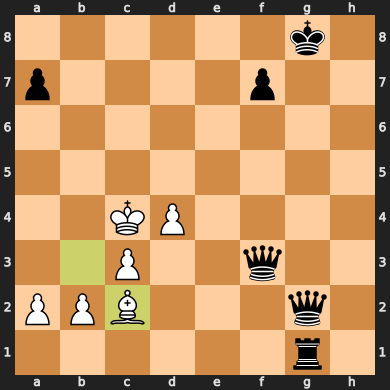



Predicted move id: 1524 with probability 0.1245
Predicted move: g1e1
Legal moves: ['g8h8', 'g8f8', 'g8g7', 'f3a8', 'f3b7', 'f3f6', 'f3c6', 'f3h5', 'f3f5', 'f3d5', 'f3g4', 'f3f4', 'f3e4', 'f3h3', 'f3g3', 'f3e3', 'f3d3', 'f3c3', 'f3f2', 'f3e2', 'f3f1', 'f3d1', 'g2g7', 'g2g6', 'g2g5', 'g2g4', 'g2h3', 'g2g3', 'g2h2', 'g2f2', 'g2e2', 'g2d2', 'g2c2', 'g2h1', 'g2f1', 'g1h1', 'g1f1', 'g1e1', 'g1d1', 'g1c1', 'g1b1', 'g1a1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


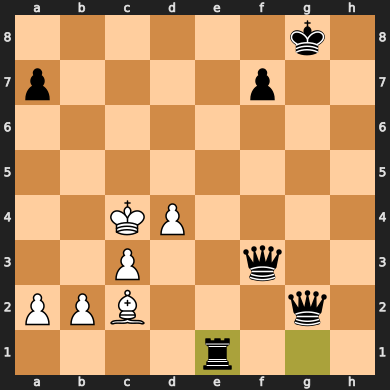



Predicted move id: 487 with probability 0.2310
Predicted move: c2b3
Legal moves: ['c4c5', 'c4b5', 'c4b4', 'c4b3', 'c2h7', 'c2g6', 'c2f5', 'c2e4', 'c2a4', 'c2d3', 'c2b3', 'c2d1', 'c2b1', 'd4d5', 'b2b3', 'a2a3', 'b2b4', 'a2a4']


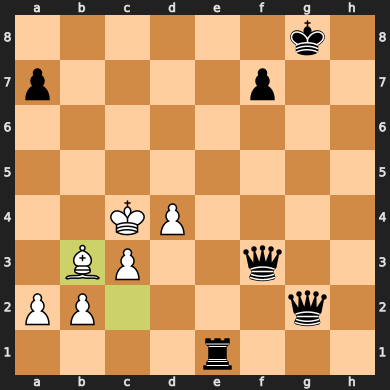



Predicted move id: 1335 with probability 0.1292
Predicted move: f3f2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'f3a8', 'f3b7', 'f3f6', 'f3c6', 'f3h5', 'f3f5', 'f3d5', 'f3g4', 'f3f4', 'f3e4', 'f3h3', 'f3g3', 'f3e3', 'f3d3', 'f3c3', 'f3f2', 'f3e2', 'f3f1', 'f3d1', 'g2g7', 'g2g6', 'g2g5', 'g2g4', 'g2h3', 'g2g3', 'g2h2', 'g2f2', 'g2e2', 'g2d2', 'g2c2', 'g2b2', 'g2h1', 'g2g1', 'g2f1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


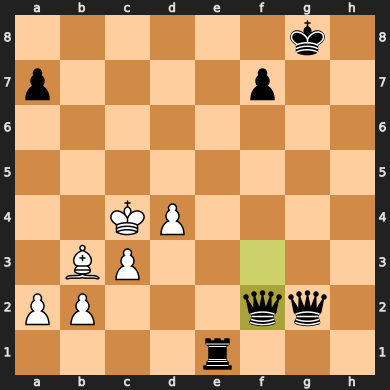



Predicted move id: 569 with probability 0.2007
Predicted move: c4d3
Legal moves: ['c4c5', 'c4b5', 'c4b4', 'c4d3', 'b3a4', 'b3c2', 'b3d1', 'd4d5', 'a2a3', 'a2a4']


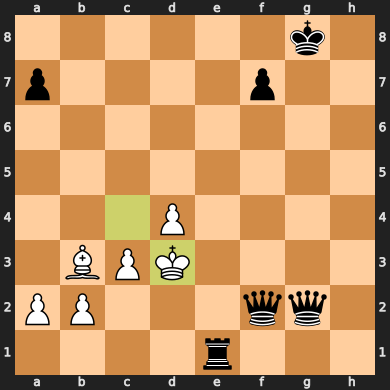



Predicted move id: 1286 with probability 0.1509
Predicted move: f2d4
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g2a8', 'g2g7', 'g2b7', 'g2g6', 'g2c6', 'g2g5', 'g2d5', 'g2g4', 'g2e4', 'g2h3', 'g2g3', 'g2f3', 'g2h2', 'g2h1', 'g2g1', 'g2f1', 'f2f6', 'f2f5', 'f2h4', 'f2f4', 'f2d4', 'f2g3', 'f2f3', 'f2e3', 'f2e2', 'f2d2', 'f2c2', 'f2b2', 'f2g1', 'f2f1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'a7a6', 'a7a5']


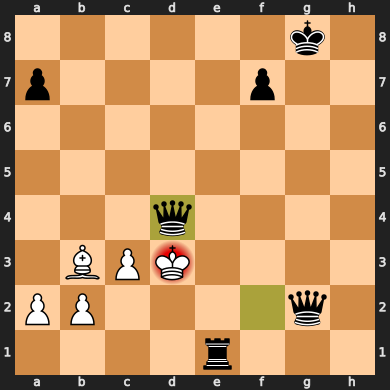



Predicted move id: 538 with probability 0.6844
Predicted move: c3d4
Legal moves: ['d3d4', 'c3d4']


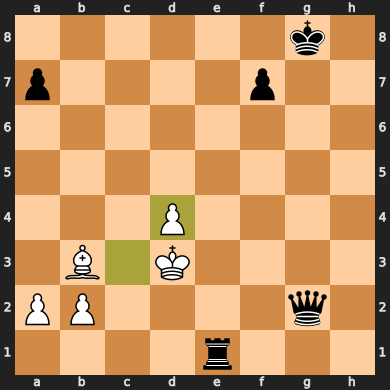



Predicted move id: 1557 with probability 0.1121
Predicted move: g2f2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'g2a8', 'g2g7', 'g2b7', 'g2g6', 'g2c6', 'g2g5', 'g2d5', 'g2g4', 'g2e4', 'g2h3', 'g2g3', 'g2f3', 'g2h2', 'g2f2', 'g2e2', 'g2d2', 'g2c2', 'g2b2', 'g2h1', 'g2g1', 'g2f1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'a7a6', 'a7a5']


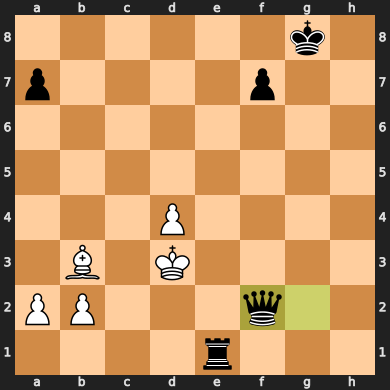



Predicted move id: 792 with probability 0.5372
Predicted move: d3c4
Legal moves: ['d3c4', 'd3c3', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'd4d5', 'a2a3', 'a2a4']


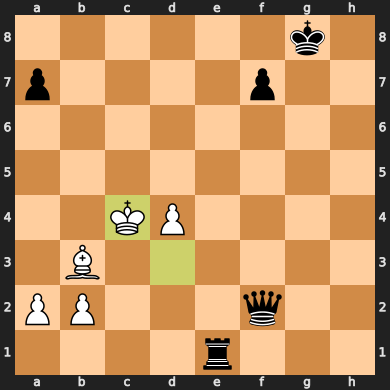



Predicted move id: 1286 with probability 0.1575
Predicted move: f2d4
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'f2f6', 'f2f5', 'f2h4', 'f2f4', 'f2d4', 'f2g3', 'f2f3', 'f2e3', 'f2h2', 'f2g2', 'f2e2', 'f2d2', 'f2c2', 'f2b2', 'f2g1', 'f2f1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


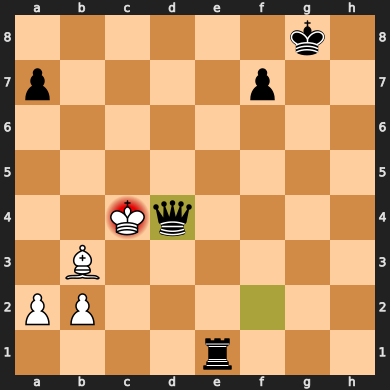



Predicted move id: 559 with probability 0.5552
Predicted move: c4b5
Legal moves: ['c4b5', 'c4d4']


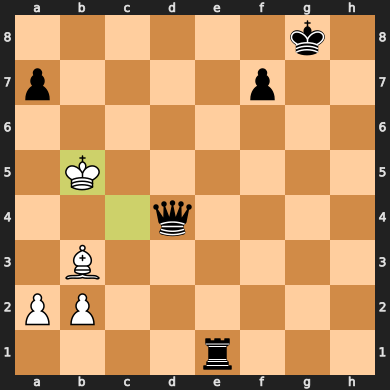



Predicted move id: 840 with probability 0.0990
Predicted move: d4f2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'd4h8', 'd4d8', 'd4g7', 'd4d7', 'd4f6', 'd4d6', 'd4b6', 'd4e5', 'd4d5', 'd4c5', 'd4h4', 'd4g4', 'd4f4', 'd4e4', 'd4c4', 'd4b4', 'd4a4', 'd4e3', 'd4d3', 'd4c3', 'd4f2', 'd4d2', 'd4b2', 'd4g1', 'd4d1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'a7a6', 'a7a5']


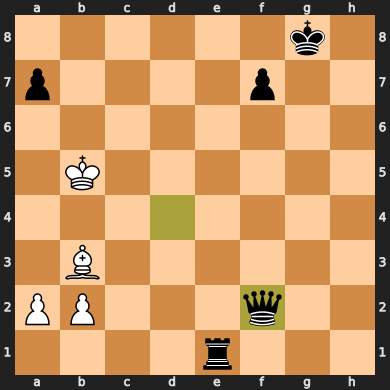



Predicted move id: 344 with probability 0.2292
Predicted move: b5c4
Legal moves: ['b5c6', 'b5a6', 'b5a5', 'b5c4', 'b5b4', 'b5a4', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'a2a3', 'a2a4']


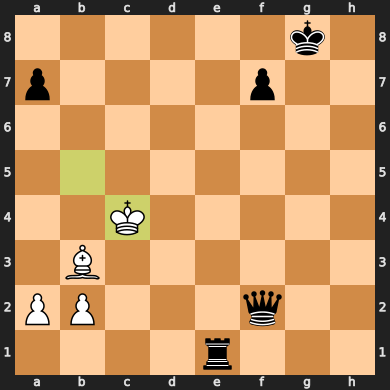



Predicted move id: 1286 with probability 0.1038
Predicted move: f2d4
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'f2f6', 'f2b6', 'f2f5', 'f2c5', 'f2h4', 'f2f4', 'f2d4', 'f2g3', 'f2f3', 'f2e3', 'f2h2', 'f2g2', 'f2e2', 'f2d2', 'f2c2', 'f2b2', 'f2g1', 'f2f1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


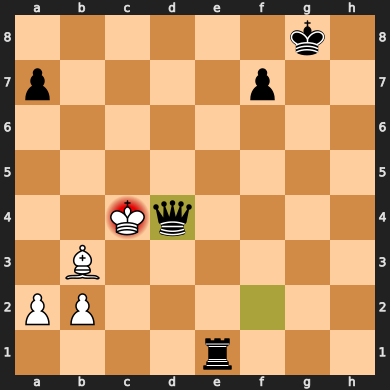



Predicted move id: 559 with probability 0.5552
Predicted move: c4b5
Legal moves: ['c4b5', 'c4d4']


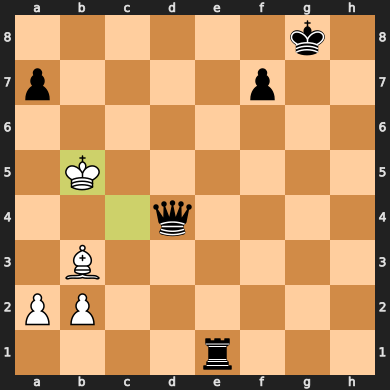



Predicted move id: 840 with probability 0.0990
Predicted move: d4f2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'd4h8', 'd4d8', 'd4g7', 'd4d7', 'd4f6', 'd4d6', 'd4b6', 'd4e5', 'd4d5', 'd4c5', 'd4h4', 'd4g4', 'd4f4', 'd4e4', 'd4c4', 'd4b4', 'd4a4', 'd4e3', 'd4d3', 'd4c3', 'd4f2', 'd4d2', 'd4b2', 'd4g1', 'd4d1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'a7a6', 'a7a5']


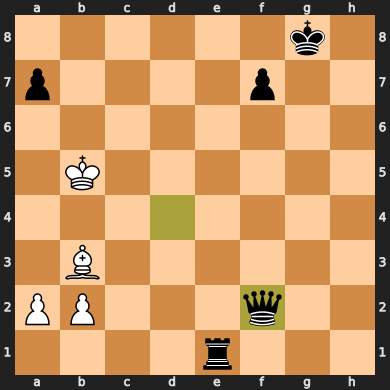



Predicted move id: 344 with probability 0.2292
Predicted move: b5c4
Legal moves: ['b5c6', 'b5a6', 'b5a5', 'b5c4', 'b5b4', 'b5a4', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'a2a3', 'a2a4']


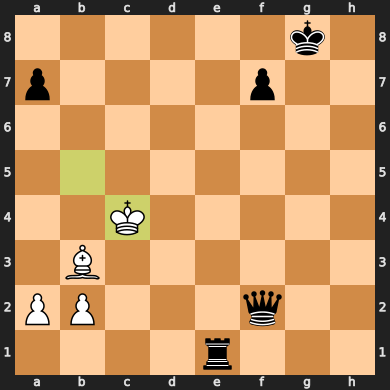



Predicted move id: 1286 with probability 0.1038
Predicted move: f2d4
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'f2f6', 'f2b6', 'f2f5', 'f2c5', 'f2h4', 'f2f4', 'f2d4', 'f2g3', 'f2f3', 'f2e3', 'f2h2', 'f2g2', 'f2e2', 'f2d2', 'f2c2', 'f2b2', 'f2g1', 'f2f1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


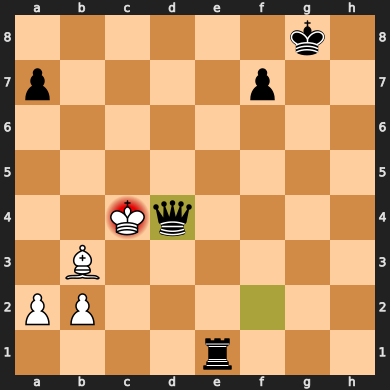



Predicted move id: 559 with probability 0.5552
Predicted move: c4b5
Legal moves: ['c4b5', 'c4d4']


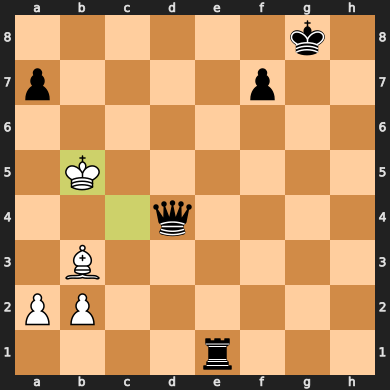



Predicted move id: 840 with probability 0.0990
Predicted move: d4f2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'd4h8', 'd4d8', 'd4g7', 'd4d7', 'd4f6', 'd4d6', 'd4b6', 'd4e5', 'd4d5', 'd4c5', 'd4h4', 'd4g4', 'd4f4', 'd4e4', 'd4c4', 'd4b4', 'd4a4', 'd4e3', 'd4d3', 'd4c3', 'd4f2', 'd4d2', 'd4b2', 'd4g1', 'd4d1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'a7a6', 'a7a5']


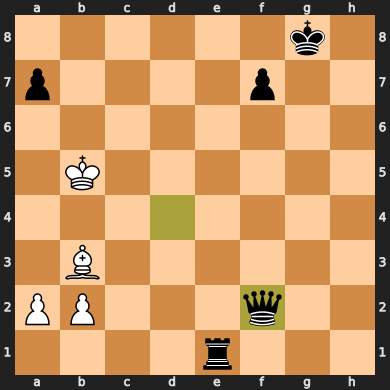



Predicted move id: 344 with probability 0.2292
Predicted move: b5c4
Legal moves: ['b5c6', 'b5a6', 'b5a5', 'b5c4', 'b5b4', 'b5a4', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'a2a3', 'a2a4']


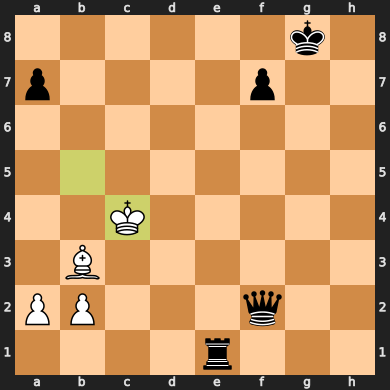



Predicted move id: 1286 with probability 0.1038
Predicted move: f2d4
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'f2f6', 'f2b6', 'f2f5', 'f2c5', 'f2h4', 'f2f4', 'f2d4', 'f2g3', 'f2f3', 'f2e3', 'f2h2', 'f2g2', 'f2e2', 'f2d2', 'f2c2', 'f2b2', 'f2g1', 'f2f1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


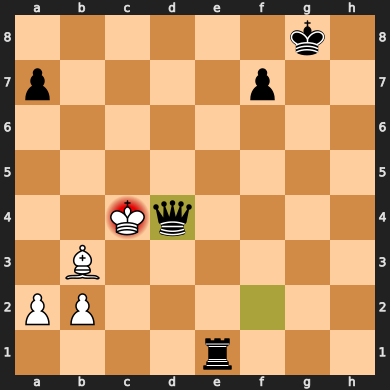



Predicted move id: 559 with probability 0.5552
Predicted move: c4b5
Legal moves: ['c4b5', 'c4d4']


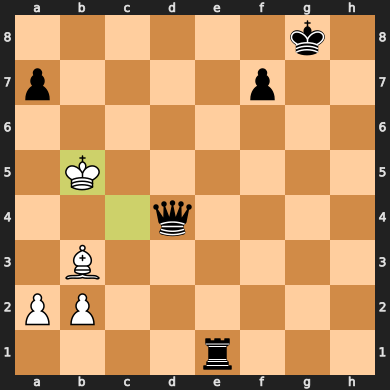



Predicted move id: 840 with probability 0.0990
Predicted move: d4f2
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'd4h8', 'd4d8', 'd4g7', 'd4d7', 'd4f6', 'd4d6', 'd4b6', 'd4e5', 'd4d5', 'd4c5', 'd4h4', 'd4g4', 'd4f4', 'd4e4', 'd4c4', 'd4b4', 'd4a4', 'd4e3', 'd4d3', 'd4c3', 'd4f2', 'd4d2', 'd4b2', 'd4g1', 'd4d1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'a7a6', 'a7a5']


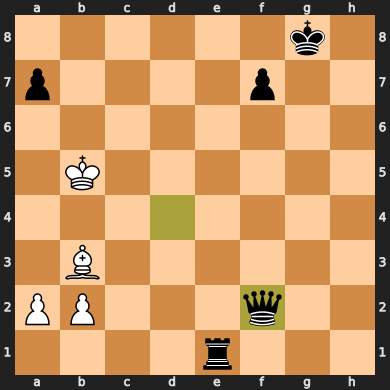



Predicted move id: 344 with probability 0.2292
Predicted move: b5c4
Legal moves: ['b5c6', 'b5a6', 'b5a5', 'b5c4', 'b5b4', 'b5a4', 'b3f7', 'b3e6', 'b3d5', 'b3c4', 'b3a4', 'b3c2', 'b3d1', 'a2a3', 'a2a4']


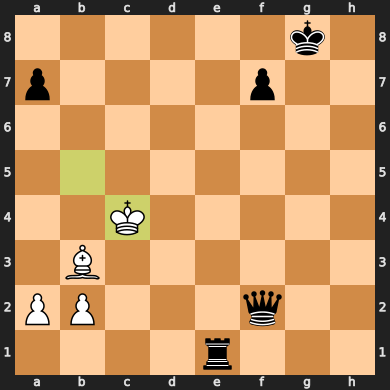



Predicted move id: 1286 with probability 0.1038
Predicted move: f2d4
Legal moves: ['g8h8', 'g8f8', 'g8h7', 'g8g7', 'f2f6', 'f2b6', 'f2f5', 'f2c5', 'f2h4', 'f2f4', 'f2d4', 'f2g3', 'f2f3', 'f2e3', 'f2h2', 'f2g2', 'f2e2', 'f2d2', 'f2c2', 'f2b2', 'f2g1', 'f2f1', 'e1e8', 'e1e7', 'e1e6', 'e1e5', 'e1e4', 'e1e3', 'e1e2', 'e1h1', 'e1g1', 'e1f1', 'e1d1', 'e1c1', 'e1b1', 'e1a1', 'f7f6', 'a7a6', 'f7f5', 'a7a5']


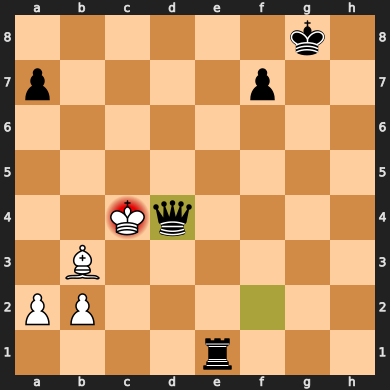



Game over
1/2-1/2


In [8]:
while not board.is_game_over():
    predicted_move, proba = predict(board)
    board.push_uci(predicted_move)
    display(board)
    print("\n")
    if board.is_game_over():
        # print the result
        print("Game over")
        print(board.result())